## Summary 

Author: Trenton Bricken

1. Plotting the text inputs that are put into GPT2 in order to try and infer it's empirical $\beta$ values used.
2. Running these texts through GPT2 to compute their Key and Query values and retrieve their dot product to infer the interval of input values that go into the Attention Softmax functions for all Attention heads across all layers.

cd to this directory then: 
pip install -e .

### Sources used for the text inputs: 
* Alice and wonderland: https://gist.github.com/phillipj/4944029
* reddit story 1: https://www.reddit.com/r/stories/comments/50yi2d/prettier_pt_3/
* reddit story 2: https://www.reddit.com/r/stories/comments/ermiqv/i_will_never_take_a_shit_at_school_or_someones/
* attention is all you need paper: https://arxiv.org/pdf/1706.03762.pdf
* SDM book chapter: https://redwood.berkeley.edu/wp-content/uploads/2020/08/KanervaP_SDMrelated_models1993.pdf

## 1. Pretty Plot of Text Inputs

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm
from scipy.sparse import csc_matrix, coo_matrix, csr_matrix
import pandas as pd
from scipy.integrate import quad
#from sympy import *
import time
from SDM_Circ_Inter_Funcs import *
import pickle
directory = 'GPT2Outputs/'

texts = []
with open('text_inputs.txt') as f:
    lines = f.readlines()
    for l in lines: 
        texts.append(l.strip('\r\n'))

lines[0]

'We’ve trained a large language model called GPT-2 that generates realistic paragraphs of text, while also exhibiting zero shot generalization on tasks like machine translation, question answering, reading comprehension, and summarization - problems usually approached by using training datasets and models designed explicitly for these tasks. A typical approach to language modeling is to learn the following task: predict the next word, given all of the previous words within some text. Last year, OpenAI’s Generative Pre-trained Transformer (GPT) showed that language models trained on large amounts of data can be fine-tuned to specific tasks to achieve high performance. GPT-2 shows that much larger language models trained on a more diverse dataset derived from the internet begin to learn these NLP tasks without needing task-specific training data, instead learning from examples the system derives from the raw text. These systems also display a substantial qualitative jump in the realism a

In [171]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [172]:
lens = []
for t in texts: 
    lens.append(tokenizer(t, return_tensors='pt')['input_ids'].shape[1])

In [173]:
df = pd.DataFrame([texts, lens]).T
pd.set_option('display.max_colwidth', -1)
df.columns = ['Text', 'Token Lengths']
df

/Users/trentonbricken/anaconda3/envs/ed2/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


Text  \
0  We’ve trained a large language model called GPT-2 that generates realistic paragraphs of text, while also exhibiting zero shot generalization on tasks like machine translation, question answering, reading comprehension, and summarization - problems usually approached by using training datasets and models designed explicitly for these tasks. A typical approach to language modeling is to learn the following task: predict the next word, given all of the previous words within some text. Last year, OpenAI’s Generative Pre-trained Transformer (GPT) showed that language models trained on large amounts of data can be fine-tuned to specific tasks to achieve high performance. GPT-2 shows that much larger language models trained on a more diverse dataset derived from the internet begin to learn these NLP tasks without needing task-specific training data, instead learning from examples the system derives from the raw text. These systems also display a substantial qualitative jump in the realism and coherence of generated text.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [138]:
import dataframe_image as dfi

# will save a high res screenshot of the dataframe. 
#dfi.export(df, directory+"TransformerTextInputsTable.png")

ModuleNotFoundError: No module named 'dataframe_image'

## 2. Computing Softmax Input Intervals

Have custom modified the Hugging Face codebase to return the key value and query matrices. (Using its implementation we could not get out the query matrix that is crucial for computing the size of the vector dot products that go into the softmax)

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.optim as optim
import pandas as pd 
from IPython.display import display
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

############ Parameters:

modelname = 'gpt2-small'#'bert-base-uncased' #'gpt2-xl' #gpt2-small is in fact the small model. 

if 'lm-' in modelname: 
    modelname_toload = modelname.split('lm-')[-1]
elif modelname=='gpt2-small':
    modelname_toload = 'gpt2' # this is the Hugging Face name for the small model
else: 
    modelname_toload = modelname

if 'gpt2-small' in modelname:
    layers=12
    nheads= 12
elif 'gpt2-large' in modelname:
    layers=36
    nheads= 20
elif 'gpt2-xl' in modelname:
    layers=48
    nheads= 25

In [193]:

if 'gpt' in modelname: 

    from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
    tokenizer = GPT2Tokenizer.from_pretrained(modelname_toload)
    if 'lm-' in modelname: 
        model = GPT2LMHeadModel.from_pretrained(modelname_toload, output_attentions=True, output_hidden_states=True).to(device)
    else: 
        model = GPT2Model.from_pretrained(modelname_toload, output_attentions=True, output_hidden_states=True).to(device)

elif 'bert' in modelname: 

    from transformers import BertTokenizer, BertModel, BertLMHeadModel
    # Download model and configuration from huggingface.co and cache.
    tokenizer = BertTokenizer.from_pretrained(modelname_toload)
    model = BertLMHeadModel.from_pretrained(modelname_toload, output_attentions=True, output_hidden_states=True).to(device)


Init GPT2 hello world and custom code!!!


In [194]:
tokenizer(texts[0], return_tensors='pt')['input_ids'].shape

torch.Size([1, 195])

In [195]:
encoded_input = tokenizer(texts[0], return_tensors='pt')
output = model(**encoded_input)
output.keys()

odict_keys(['last_hidden_state', 'past_key_values', 'hidden_states', 'kqvs', 'attentions'])

In [196]:
len(output['past_key_values'])

12

In [197]:
len(output['kqvs'])

12

## Checking that I customized the code to get out the keys, queries, and values correctly and evaluating tensor shapes

In [198]:
output['past_key_values'][5][0].shape

torch.Size([1, 12, 195, 64])

In [199]:
output['kqvs'][5][0].shape

torch.Size([1, 12, 195, 64])

In [200]:
# output['past_key_values'][LAYER][0=KEY, 1=VALUE][batch_size, num_heads, sequence_length, embed_size_per_head]
# output['kqvs'][LAYER][KEY=0, QUERY=1, VALUE=2][batch_size, num_heads, sequence_length, embed_size_per_head]

output['past_key_values'][5][0][0,3,:,:] == output['kqvs'][5][0][0,3,:,:]

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [201]:
key, query, value = output['kqvs'][2] #[0][0,3,:,:]

In [202]:
query[0,:,-1,:].unsqueeze(-1).shape

torch.Size([12, 64, 1])

In [203]:
key[0,:,:,:].shape

torch.Size([12, 195, 64])

In [204]:
torch.matmul(key[0,:,:,:], query[0,:,-1,:].unsqueeze(-1)).squeeze().shape

torch.Size([12, 195])

In [205]:
output['attentions'][3][0,:,-1,:].shape

torch.Size([12, 195])

In [206]:
np.linalg.norm(value[0,:,:,:].detach().numpy(), axis=2).shape

(12, 195)

In [207]:
value[0,:,:,:].shape

torch.Size([12, 195, 64])

## Collecting Keys, Queries, Values, and Attention for every text input

text index is: 0


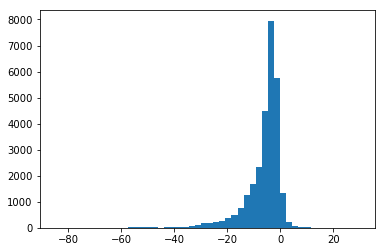

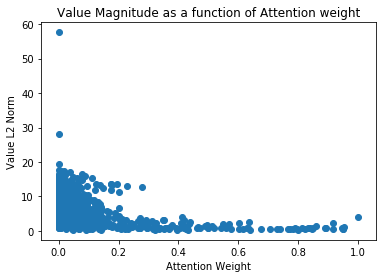

text index is: 1


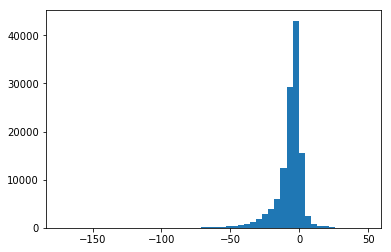

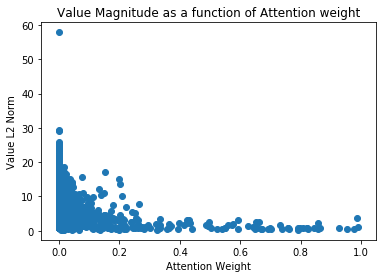

text index is: 2


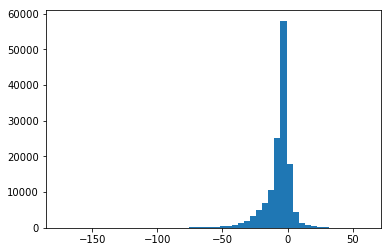

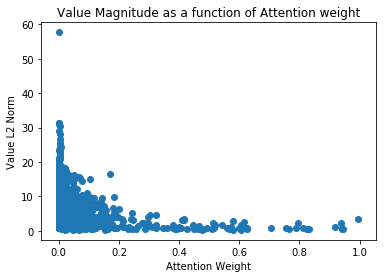

text index is: 3


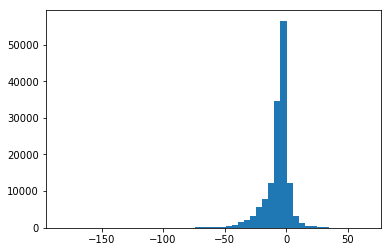

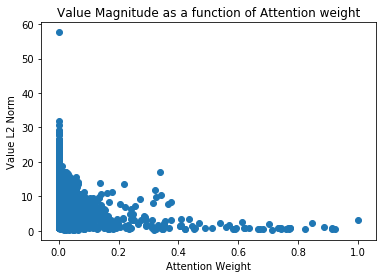

text index is: 4


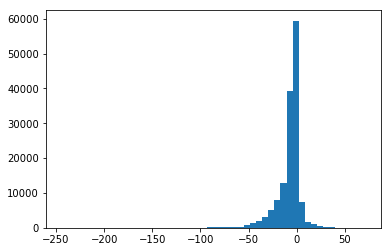

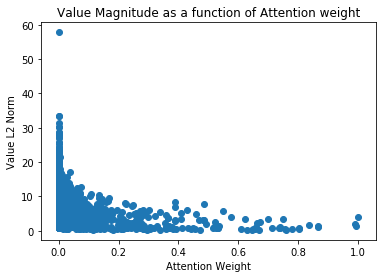

text index is: 5


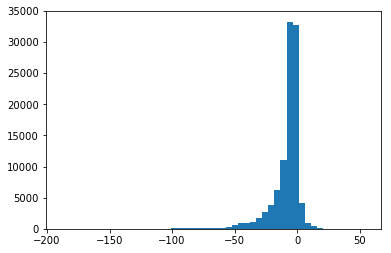

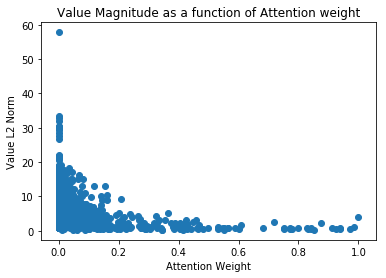

text index is: 6


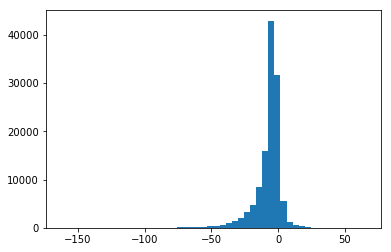

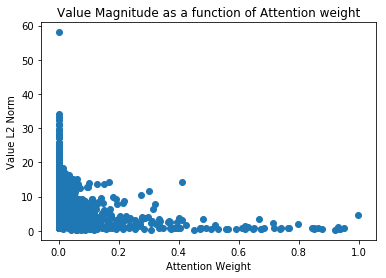

text index is: 7


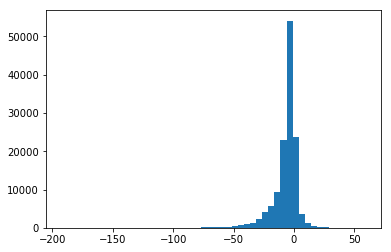

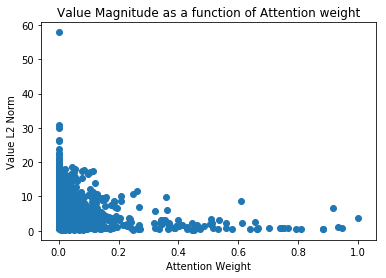

text index is: 8


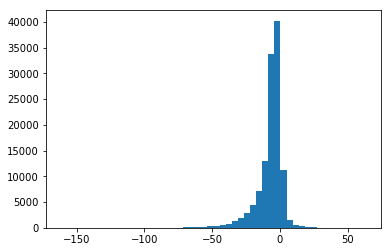

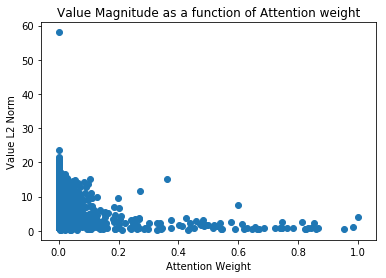

In [208]:
verbose = False 
beta = 1/np.sqrt(64)
over_texts = dict()

for text_ind, text in enumerate(texts): 
    print('text index is:', text_ind)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    input_len = encoded_input['input_ids'].shape[1]

    # storing the processed results: 
    h_summary = dict()
    l_summary = dict()
    
    for l_ind in range(layers):
        if verbose: 
            print('layer is:', l_ind)
        
        key, query, value = output['kqvs'][l_ind] #[0][0,3,:,:]
        
        # if not working with just the last input need to do masking. Not doing this here. 
        # code should look something like this. 
        #K_masked = K[:, :, :(inp_ind+1),:]
    
        sm_inputs = beta*torch.matmul(key[0,:,:,:], query[0,:,-1,:].unsqueeze(-1)).squeeze().detach().numpy() # [NHEADS, SEQLEN] 
        
        if verbose:
            print('softmax inputs shpae', sm_inputs.shape)
        V_norms = np.linalg.norm(value[0,:,:,:].detach().numpy(), axis=2)
        A = output['attentions'][l_ind][0,:,-1,:].detach() # # [NHEADS, SEQLEN]
        layer_dtypes = np.stack([sm_inputs, V_norms, A],axis=0)[np.newaxis,:]
        if l_ind==0:
            all_layers_res = layer_dtypes
        else: 
            all_layers_res = np.concatenate([all_layers_res, layer_dtypes],axis=0)
    
        # max for each of the heads. 
        maxs = sm_inputs.max(axis=1)
        mins = sm_inputs.min(axis=1)
        intervals = pd.DataFrame([mins,maxs])
        if verbose: 
            print('observed interval is:')
            display(intervals.T)
            print('mean value of maxes for each head in layer:', np.mean(maxs))
            print('median:', np.median(maxs))
            print('max of maxes:', np.max(maxs))
            
        # max of each head logging each layer
        h_summary[l_ind] = maxs
        # summary across heads for each layer
        l_summary[l_ind] = [np.mean(maxs), np.median(maxs), np.max(maxs) ]
        
        
    # all_layers_res: Layers x Dtypes x Heads x SeqLen
    
    # input to softmax for all layers. 
    plt.figure()
    plt.hist(all_layers_res[:,0,:,:].flatten(), bins=50)
    plt.gcf().savefig(directory + modelname+'AllLayerPreSMs|text_ind='+str(text_ind)+'.png', dpi=250)
    plt.show()
    
    plt.figure()
    plt.scatter(all_layers_res[:,2,:,:].flatten(), all_layers_res[:,1,:,:].flatten())
    plt.xlabel("Attention Weight")
    plt.ylabel("Value L2 Norm")
    plt.title("Value Magnitude as a function of Attention weight")
    plt.gcf().savefig(directory + modelname+'AllLayerValMagAttWeight|text_ind='+str(text_ind)+'.png', dpi=250)
    plt.show()

    l_summary = pd.DataFrame(l_summary).T
    l_summary.columns = ['mean', 'median', 'max']
    # rows are layers and columns are heads
    h_summary = pd.DataFrame(h_summary).T
    
    if verbose: 
        display(l_summary)
        display(h_summary)
    
    # saving out these summaries: 
    over_texts[text_ind] = (l_summary, h_summary, all_layers_res)
    
with open(directory+modelname+"results_over_all_texts.pkl", 'wb') as fname: 
    pickle.dump(over_texts, fname)

In [210]:
all_layers_res.shape # Layers x Dtypes x Heads x SeqLen

(12, 3, 12, 844)

## Plotting various aggregations of the heads, layers, and texts to get the effective $\beta$ and also investigate the relationship between attention weights and the value vector's L2 norm

In [ ]:
import pickle
with open(directory+modelname+"results_over_all_texts.pkl", 'rb') as fname: 
    over_texts = pickle.load( fname)

text ind 0
text ind 1
text ind 2
text ind 3
text ind 4
text ind 5
text ind 6
text ind 7
text ind 8
Summary of all:


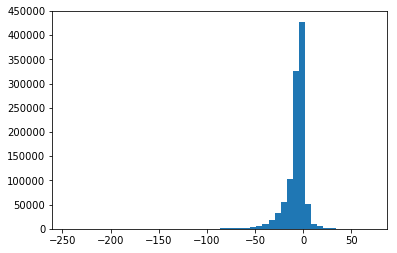

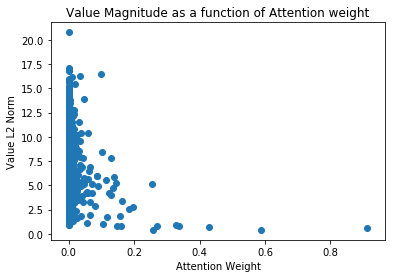

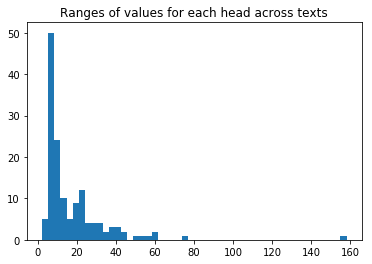

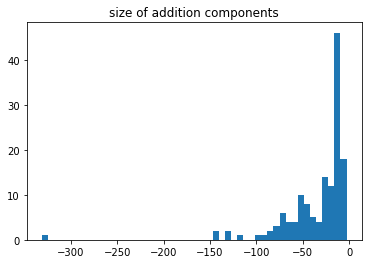

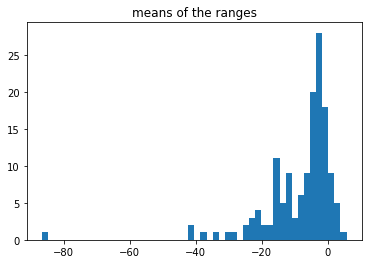

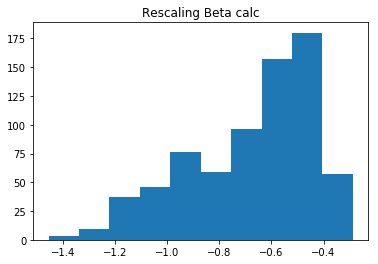

In [211]:
# replotting the results from before but also aggregating across them. 
for text_ind, text in enumerate(texts):
    print('text ind', text_ind)
    #print(text)
    # saving out these summaries: 
    l_summary, h_summary, all_layers_res = over_texts[text_ind]

    # input to softmax for all layers. 
    #all_layers_res = all_layers_res[np.newaxis, :]
    if text_ind==0: 
        all_text_vals = all_layers_res
    else: 
        #print(all_text_vals.shape, all_layers_res.shape)
        all_text_vals = np.concatenate([all_text_vals, all_layers_res], axis=-1)
    #plt.hist(all_layers_res[:,0,:,:].flatten(), bins=50)
    #plt.gcf().savefig(directory+modelname+'AllLayerPreSMs|text_ind='+str(text_ind)+'.png', dpi=250)
    #plt.show()

    #display(l_summary)
    #display(h_summary)
    
# all_text_vals:  Layers x Dtypes x Heads x (SeqLen * Texts, all combined!)
print("Summary of all:")
plt.hist(all_text_vals[:,0,:,:].flatten(), bins=50)
plt.gcf().savefig(directory+modelname+'SMValuesForAllTextsLayersHeads.png', dpi=250)
plt.show()

plt.figure()
number_to_plot = 10000
rand_inds = np.random.choice(np.arange(len(all_text_vals[:,2,:,:].flatten())),number_to_plot, replace =False)
plt.scatter(all_text_vals[:,2,:,:].flatten()[rand_inds], all_text_vals[:,1,:,:].flatten()[rand_inds])
plt.xlabel("Attention Weight")
plt.ylabel("Value L2 Norm")
plt.title("Value Magnitude as a function of Attention weight")
plt.gcf().savefig(directory + modelname+'ValuesvsAttentionAllTextsLayersHeads.png', dpi=250)
plt.show()

############

plt.figure()

r_min = np.min(all_text_vals[:,0,:,:], axis=-1)
r_max = np.max(all_text_vals[:,0,:,:], axis=-1)
ranges = np.abs(r_max-r_min)
mu = (r_max+r_min)/2
size_of_addition_components = mu + r_min

plt.hist(ranges.flatten()/2, bins =50)
plt.title("Ranges of values for each head across texts")
plt.show()

plt.figure()
plt.hist(size_of_addition_components.flatten(), bins =50)
plt.title("size of addition components")
plt.show()

plt.figure()
plt.hist(mu.flatten(), bins =50)
plt.title("means of the ranges")
plt.show()

plt.figure()
#rescaling_betas = ((2*np.abs(r_min))/ranges) -2
#print(ranges*rescaling_betas)
plt.title("Rescaling Beta calc")
plt.hist(rescaling_betas.flatten())
plt.show()

gpt2-small


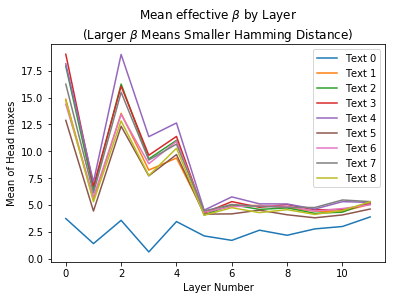

gpt2-large


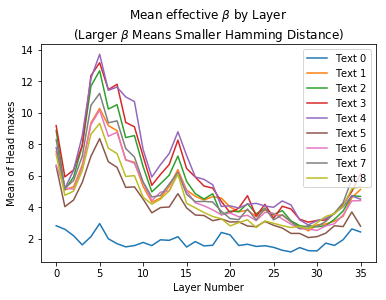

In [3]:
### How do results differ between the models?!
import pickle
models = ['gpt2-small', 'gpt2-large'] # did not make a big difference 'lm-gpt2-large']

valsforall = {k:{kk:[] for kk in ['sm', 'vals', 'att']} for k in models}

for m in models: 
        
    print(m)
    
    with open(directory+m+"results_over_all_texts.pkl", 'rb') as fname: 
            model_over_texts = pickle.load( fname)

    for text_ind, text in enumerate(texts):

        #print(text)

        l_summary, h_summary, all_layer_vals = model_over_texts[text_ind]
        
        '''sm_inputs, val_norms, attns = all_layer_vals[:,0], all_layer_vals[:,1], all_layer_vals[:,2]
        
        # input to softmax for all layers.
        print(sm_inputs.shape)
        valsforall[m]['sm'] += list(sm_inputs)
        valsforall[m]['vals'] += list(val_norms)
        valsforall[m]['att'] += list(attns)
        plt.hist(sm_inputs, bins=50, alpha=0.5, label=m, density=True)'''
        #print('l and then h summary. these are the max sm inputs.')
        #display(l_summary)
        #display(h_summary)
        plt.plot(l_summary.index, l_summary['mean'], label = 'Text '+str(text_ind))
    plt.legend()
    plt.ylabel('Mean of Head maxes')
    plt.xlabel('Layer Number')
    #plt.xlim(-max(sm_inputs),max(sm_inputs))
    plt.title(r"Mean effective $\beta$ by Layer"+ "\n"+r"(Larger $\beta$ Means Smaller Hamming Distance)")
    plt.gcf().savefig(directory+'PerModelLayerAverageBetas_'+str(m)+'.png', dpi=250)
    plt.show()

    print('======================')
    

gpt2-small


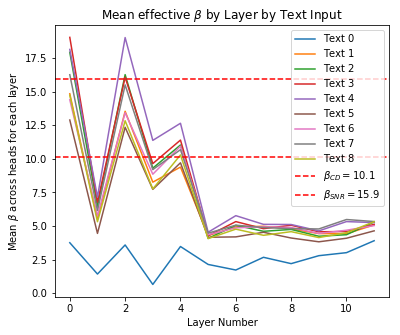

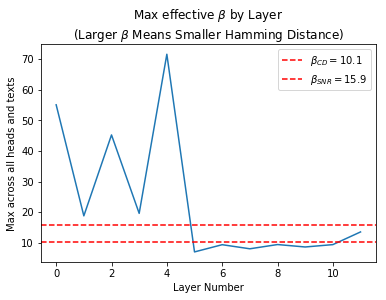

No handles with labels found to put in legend.


dim of heads being plotted (12, 12)


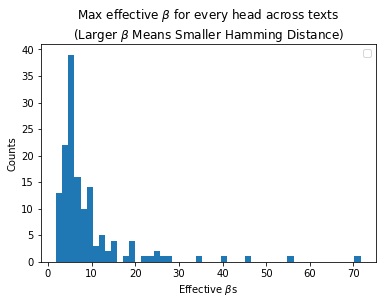

gpt2-large


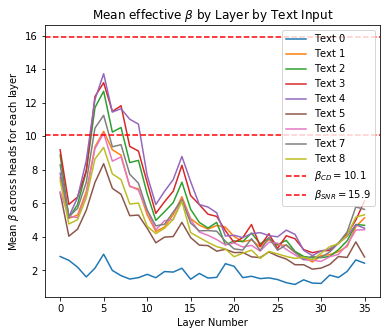

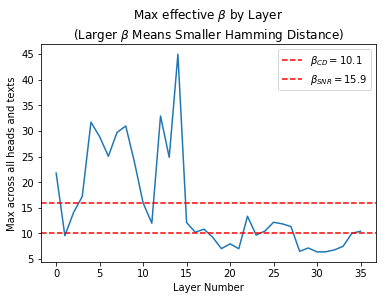

No handles with labels found to put in legend.


dim of heads being plotted (36, 20)


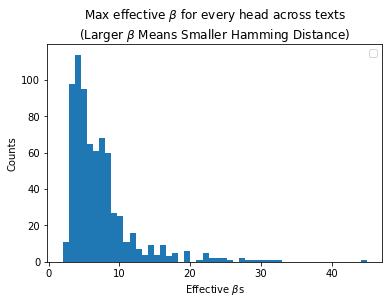

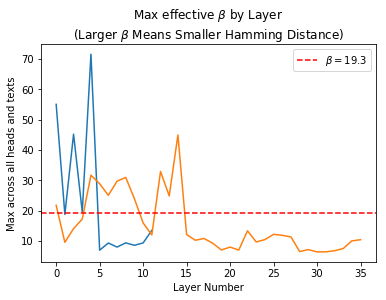

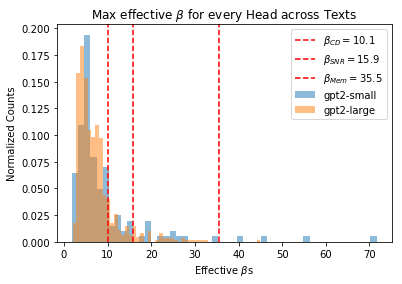

In [10]:
models = ['gpt2-small', 'gpt2-large'] # did not make a big difference 'lm-gpt2-large']

valsforall = {k:{kk:[] for kk in ['sm', 'vals', 'att']} for k in models}

across_models, heads_across_models = [], []
for m in models: 
        
    print(m)
    if 'small' in m:
        nlay = 12
    else: 
        nlay = 36
    
    with open(directory+m+"results_over_all_texts.pkl", 'rb') as fname: 
            model_over_texts = pickle.load( fname)

    max_seen = np.zeros((nlay,1))
    
    heads_max_seen = 0
    
    plt.figure(figsize=(6,5))
            
    for text_ind, text in enumerate(texts):

        #print(text)

        l_summary, h_summary, all_layer_vals = model_over_texts[text_ind]
        
        max_seen = np.concatenate([max_seen, 
                                   np.asarray(l_summary['max']).reshape(-1,1)], axis=1)
        
        if text_ind==0:
            heads_max_seen = np.asarray(h_summary).reshape(h_summary.shape[0], h_summary.shape[1], 1)
        else: 
            heads_max_seen = np.concatenate([heads_max_seen, 
                                   np.asarray(h_summary).reshape(h_summary.shape[0], h_summary.shape[1], 1)], axis=2)
        
        
        '''sm_inputs, val_norms, attns = all_layer_vals[:,0], all_layer_vals[:,1], all_layer_vals[:,2]
        
        # input to softmax for all layers.
        print(sm_inputs.shape)
        valsforall[m]['sm'] += list(sm_inputs)
        valsforall[m]['vals'] += list(val_norms)
        valsforall[m]['att'] += list(attns)
        plt.hist(sm_inputs, bins=50, alpha=0.5, label=m, density=True)'''
        #print('l and then h summary. these are the max sm inputs.')
        #display(l_summary)
        #display(h_summary)
        plt.plot(l_summary.index, l_summary['mean'], label = 'Text '+str(text_ind))
    plt.axhline(10.1,  linestyle='dashed',label=r"$\beta_{CD}=10.1$", color='red')
    plt.axhline(15.9,  linestyle='dashed',label=r"$\beta_{SNR}=15.9$", color='red')
    #plt.axhline(19.3,  linestyle='dashed',label=r"$\beta=19.3$", color='red')
    plt.legend()
    plt.ylabel(r'Mean $\beta$ across heads for each layer')
    plt.xlabel('Layer Number')
    #plt.xlim(-max(sm_inputs),max(sm_inputs))
    plt.title(r"Mean effective $\beta$ by Layer by Text Input")
    plt.gcf().savefig(directory+'PerTextPerModelLayerMeanBetas_'+str(m)+'.png', dpi=250)
    plt.show()
    
    max_seen = np.nan_to_num(max_seen)
    heads_max_seen =  np.nan_to_num(heads_max_seen)
    plt.figure()
    plt.plot(l_summary.index, max_seen.max(axis=1))
    across_models.append((l_summary.index, max_seen.max(axis=1)))
    
    #plt.axhline(19.3,  linestyle='dashed',label=r"$\beta=19.3$", color='red')
    plt.axhline(10.1,  linestyle='dashed',label=r"$\beta_{CD}=10.1$", color='red')
    plt.axhline(15.9,  linestyle='dashed',label=r"$\beta_{SNR}=15.9$", color='red')
    #plt.axvline(35.5,  linestyle='dashed',label=r"$\beta_{Mem}=35.5$", color='red')
    plt.ylabel('Max across all heads and texts')
    plt.legend()
    plt.xlabel('Layer Number')
    #plt.xlim(-max(sm_inputs),max(sm_inputs))
    plt.title(r"Max effective $\beta$ by Layer"+ "\n"+r"(Larger $\beta$ Means Smaller Hamming Distance)")
    plt.gcf().savefig(directory+'PerModelLayerMaxBetas_'+str(m)+'.png', dpi=250)
    plt.show()
    
    # ========
    
    plt.figure()
    plt.hist(heads_max_seen.max(axis=2).flatten(), bins=50)
    print("dim of heads being plotted", heads_max_seen.max(axis=2).shape)
    heads_across_models.append(heads_max_seen.max(axis=2))
    
    #plt.axvline(19.3,  linestyle='dashed',label=r"$\beta=19.3$", color='red')
    plt.ylabel('Counts')
    plt.legend()
    plt.xlabel(r'Effective $\beta$s')
    #plt.xlim(-max(sm_inputs),max(sm_inputs))
    plt.title(r"Max effective $\beta$ for every head across texts"+ "\n"+r"(Larger $\beta$ Means Smaller Hamming Distance)")
    plt.gcf().savefig(directory+'PerModelLayerMaxHeadBetas_'+str(m)+'.png', dpi=250)
    plt.show()

    print('======================')
max_seen.shape

for v in across_models: 
    x, y = v
    
    plt.plot(x,y)

plt.axhline(19.3,  linestyle='dashed',label=r"$\beta=19.3$", color='red')
plt.ylabel('Max across all heads and texts')
plt.legend()
plt.xlabel('Layer Number')
#plt.xlim(-max(sm_inputs),max(sm_inputs))
plt.title(r"Max effective $\beta$ by Layer"+ "\n"+r"(Larger $\beta$ Means Smaller Hamming Distance)")
plt.gcf().savefig(directory+'BothModelsLayerMaxBetas_'+str(m)+'.png', dpi=250)
plt.show()

# =======
plt.figure()
for ind, v in enumerate(heads_across_models): 
    plt.hist(v.flatten(), bins=50, alpha=0.5, density=True, label=models[ind])

#plt.axvline(19.3,  linestyle='dashed',label=r"$\beta=19.3$", color='red')
plt.axvline(10.1,  linestyle='dashed',label=r"$\beta_{CD}=10.1$", color='red')
plt.axvline(15.9,  linestyle='dashed',label=r"$\beta_{SNR}=15.9$", color='red')
plt.axvline(35.5,  linestyle='dashed',label=r"$\beta_{Mem}=35.5$", color='red')
plt.ylabel('Normalized Counts')
plt.legend()
plt.xlabel(r'Effective $\beta$s')
#plt.xlim(-max(sm_inputs),max(sm_inputs))
plt.title(r"Max effective $\beta$ for every Head across Texts")#+ "\n"+r"(Larger $\beta$ Means Smaller Hamming Distance)")
plt.gcf().savefig(directory+'BothModelsLayerMaxHeadBetas_'+str(m)+'.png', dpi=250)
plt.show()
    

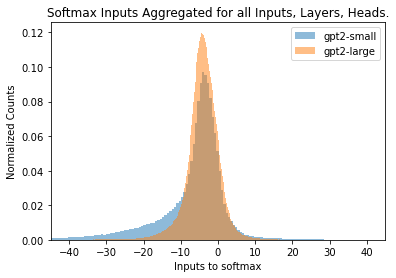

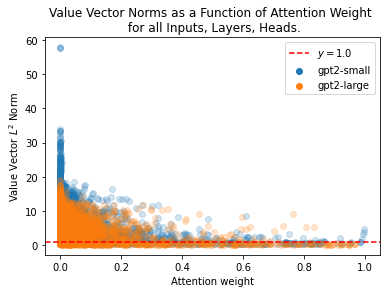

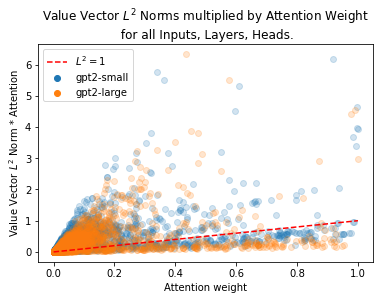

In [4]:
### How do results differ between the models?!

models = ['gpt2-small', 'gpt2-large'] # did not make a big difference 'lm-gpt2-large']

# aggregate over all texts for each model. 
second_plot = [] # storing values for second plot here so I can save them easily as separate figures. 

for m in models: 
    
    #print(m)
    
    with open(directory+m+"results_over_all_texts.pkl", 'rb') as fname: 
        model_over_texts = pickle.load( fname)

    for text_ind, text in enumerate(texts):
        #print("text ind", text_ind)
        #print(text)
        
        l_summary, h_summary, all_layers_res = model_over_texts[text_ind]
        
        if text_ind==0: 
            all_text_vals = all_layers_res
        else: 
            all_text_vals = np.concatenate([all_text_vals, all_layers_res], axis=-1)
            
        #display(l_summary)
        #display(h_summary)
        
    plt.hist(all_text_vals[:,0,:,:].flatten(), bins=500, alpha=0.5, label=m, density=True)
    
    second_plot.append((all_text_vals[:,2,:,:].flatten(), all_text_vals[:,1,:,:].flatten()))
        
#plt.axvline(19.3,  linestyle='dashed',label=r"$\beta=19.3$", color='red')
plt.legend()
plt.title("Softmax Inputs Aggregated for all Inputs, Layers, Heads.")
plt.ylabel('Normalized Counts')
plt.xlabel('Inputs to softmax')
#plt.xlim(left=0)
max_x_val = np.max(all_text_vals[:,0,:,:].flatten()) # ignores a few outlier negative values that we don't care about. 
plt.xlim(-max_x_val,max_x_val)
plt.gcf().savefig(directory+'AllModels|ValuesForAllTextsLayersHeads.png', dpi=250)
plt.show()

#------------------
plt.figure()
number_to_plot = 500000

for ind, els in enumerate(second_plot):
    x, y = els
    rand_inds = np.random.choice(np.arange(len(x)),number_to_plot, replace =False)
    plt.scatter(x[rand_inds],y[rand_inds] ,alpha=0.2, label=models[ind])
plt.axhline(1.0,  linestyle='dashed',label="$y=1.0$", color='red')

lgnd = plt.legend()
for lh in lgnd.legendHandles: 
    lh.set_alpha(1)
plt.title("Value Vector Norms as a Function of Attention Weight \n for all Inputs, Layers, Heads.")
plt.ylabel('Value Vector $L^2$ Norm')
plt.xlabel('Attention weight')
plt.gcf().savefig(directory+'AllModels|ValueVectorAttentionScatterForAllTextsLayersHeads.png', dpi=250)
plt.show()

#------------------ Multiplying value vector by attention 
plt.figure()
number_to_plot = 500000

for ind, els in enumerate(second_plot):
    x, y = els
    rand_inds = np.random.choice(np.arange(len(x)),number_to_plot, replace =False)
    plt.scatter(x[rand_inds],x[rand_inds]*y[rand_inds] ,alpha=0.2, label=models[ind])
xrang = np.linspace(0,1,100)
plt.plot(xrang, xrang, linestyle='dashed',label="$L^2=1$", color='red')
lgnd = plt.legend()
for lh in lgnd.legendHandles: 
    lh.set_alpha(1)
plt.title("Value Vector $L^2$ Norms multiplied by Attention Weight \n for all Inputs, Layers, Heads.")
plt.ylabel('Value Vector $L^2$ Norm * Attention')
plt.xlabel('Attention weight')
plt.gcf().savefig(directory+'AllModels|ValueVectorTimesAttentionScatterForAllTextsLayersHeads.png', dpi=250)
plt.show()